In [1]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:

# Definiuj transformację danych za pomocą torchvision.transforms.Compose.
# Compose pozwala na łączenie wielu transformacji w jedną.
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Konwertuj obrazy na tensory.
    lambda x: torch.floor(x * 255 / 128).squeeze(dim=0)  # Przekształć wartości pikseli.
])

# Tworzy zestaw danych treningowych MNIST z określonymi transformacjami.
mnist_train = torchvision.datasets.MNIST(
    root='./temp',  # Lokalizacja, gdzie dane zostaną zapisane.
    train=True,  # Określa, że dane treningowe zostaną pobrane.
    transform=data_transform,  # Użyj zdefiniowanej transformacji danych.
    download=True  # Pobierz dane, jeśli nie są dostępne.
)

# Tworzy zestaw danych testowych MNIST z określonymi transformacjami.
mnist_test = torchvision.datasets.MNIST(
    root='./temp',  # Lokalizacja, gdzie dane zostaną zapisane.
    train=False,  # Określa, że dane testowe zostaną pobrane.
    transform=data_transform,  # Użyj zdefiniowanej transformacji danych.
    download=True  # Pobierz dane, jeśli nie są dostępne.
)

In [3]:
image, label = mnist_train[2]
image.shape, label

(torch.Size([28, 28]), 4)

In [4]:
image.shape, image.dtype

(torch.Size([28, 28]), torch.float32)

In [5]:
label, type(label)

(4, int)

In [6]:
images = torch.stack([mnist_train[i][0] for i in range(10, 38)], dim=0)
labels = torch.tensor([mnist_train[i][1] for i in range(10, 38)])
images.shape, labels.shape

(torch.Size([28, 28, 28]), torch.Size([28]))

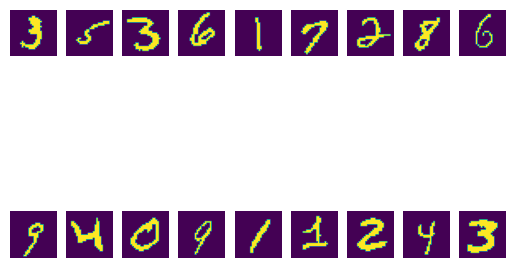

In [7]:
rows, cols = 2, 9

for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()

In [8]:
# Tworzy tensor X, który zawiera obrazy ze zbioru danych treningowych MNIST.
X = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))], dim=0)

# Tworzy tensor Y, który zawiera etykiety (klasy) odpowiadające obrazom.
Y = torch.tensor([mnist_train[i][1] for i in range(len(mnist_train))])

# Inicjalizuje tensor n_y jako tensor zerowy o długości 10 (liczba klas w MNIST).
n_y = torch.zeros(10)

# Oblicza liczbę wystąpień każdej klasy w zbiorze danych treningowych.
for y in range(10):
    n_y[y] = (Y == y).sum()

# Oblicza prawdopodobieństwo wystąpienia każdej klasy (P(Y=y)).
P_y = n_y / n_y.sum()

# Wyświetla obliczone prawdopodobieństwa.
P_y

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

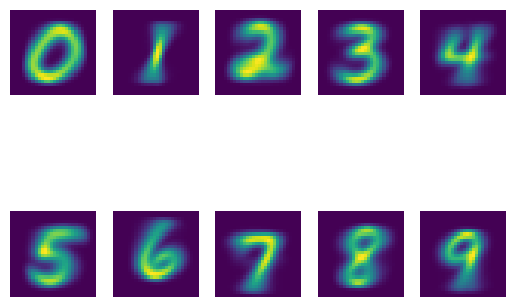

In [9]:
# Inicjalizuje tensor n_x jako tensor zerowy o kształcie (10, 28, 28), gdzie 10 to liczba klas, a (28, 28) to rozmiar obrazu.
n_x = torch.zeros((10, 28, 28))

# Oblicza sumę obrazów dla każdej klasy w zestawie danych treningowych.
for y in range(10):
    n_x[y] = torch.tensor(X.numpy()[Y.numpy() == y].sum(axis=0))

# Oblicza warunkowe prawdopodobieństwa P(X|Y=y) z wykorzystaniem wzoru Laplace'a.
# Dodaje 1 do licznika (n_x) i 2 do mianownika (n_y) dla wygładzenia Laplace'a.
P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)

# Wynikowy tensor P_xy zawiera warunkowe prawdopodobieństwa dla każdej klasy (10 klas) i każdego piksela obrazu (28x28).

rows, cols = 2, 5

for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(P_xy[i])
    plt.axis('off')

plt.show()

In [10]:
# Oblicza logarytmy prawdopodobieństw P(X|Y) oraz logarytm prawdopodobieństw P(Y).
log_P_xy = torch.log(P_xy)
log_P_xy_neg = torch.log(1 - P_xy)
log_P_y = torch.log(P_y)

# Definiuje funkcję bayes_pred_stable, która przewiduje klasę na podstawie obrazu.
def bayes_pred_stable(x):
    x = x.unsqueeze(0)  # Rozszerza tensor obrazu z (28, 28) na (1, 28, 28).
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # Oblicza sumę logarytmów P(X|Y) dla każdej klasy (p(x|y)).
    return p_xy + log_P_y  # Dodaje logarytmy P(Y) do wyniku.

# Przewiduje klasę dla danego obrazu (zmienna image).
py = bayes_pred_stable(image)

# Wynikowy tensor py zawiera logarytmy prawdopodobieństw a posteriori dla każdej z 10 klas.

In [11]:
py.argmax(dim=0) == label

tensor(True)

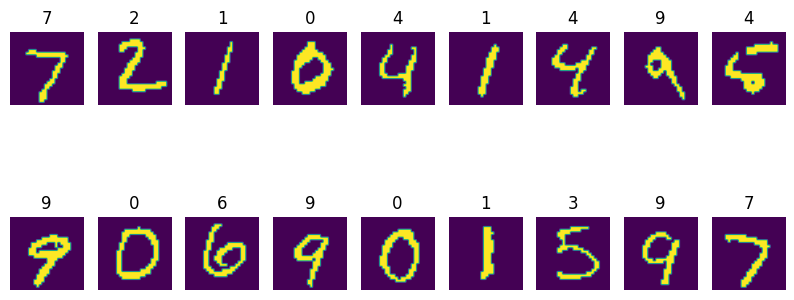

In [12]:
def predict(X):
    return [bayes_pred_stable(x).argmax(dim=0).type(torch.int32).item()
            for x in X]

X = torch.stack([mnist_test[i][0] for i in range(18)], dim=0)
y = torch.tensor([mnist_test[i][1] for i in range(18)])
preds = predict(X)

fig, axs = plt.subplots(2, 9, figsize=(10, 4))
fig.subplots_adjust(hspace=0.5)
for i in range(18):
    ax = axs[i // 9, i % 9]
    ax.imshow(X[i]) 
    ax.set_title(str(preds[i]))
    ax.axis('off')

plt.show()

In [13]:
X = torch.stack([mnist_test[i][0] for i in range(len(mnist_test))], dim=0)
y = torch.tensor([mnist_test[i][1] for i in range(len(mnist_test))])
preds = torch.tensor(predict(X), dtype=torch.int32)
float((preds == y).sum()) / len(y) 

0.8427